In [1]:
from Functions import *
from select_lc import read_lc, select_lc
from savgol import savitzky_golay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import gzip
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pickle as pkl
from numpy import math
import traceback
import sys
from tqdm import tqdm

cmd_folder = os.path.realpath(os.getenv("SESNCFAlib"))

if cmd_folder not in sys.path:
     sys.path.insert(0, cmd_folder)
import templutils as templutils

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
lc_direc = os.getenv("SESNPATH") + './../Somayeh_contributions/main/ELASTICC_lc/'

SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']

bands = ['R','V','r','g','U','u','J','B','H','I','i','K','m2','w1','w2']
colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'Ibn':'purple'}

lsst_bands = {'0':'u',
              '1':'g',
              '2': 'r',
              '3': 'i',
              '4': 'z',
              '5': 'y'}

clrs =  {'0':'b',
              '1':'g',
              '2': 'r',
              '3': 'purple',
              '4': 'cyan',
              '5': 'k'}

su = templutils.setupvars()
coffset = su.coffset

In [3]:
# Reading in GP templates in any bands requested

tmpl = {}

bands = ['up', 'g', 'rp', 'ip']

for bb in bands:

    tmpl[bb[0]] = {}

    for SNTYPE in SNTYPES:
        
        tmpl[bb[0]][SNTYPE] = {}


        try:
            path = os.getenv("SESNPATH") + "maketemplates/outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl"%(SNTYPE,bb)
            tmpl_ = pkl.load(open(path, "rb"))
        except:
            continue
        
#         print(tmpl_['rollingMedian'])

        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue

        tmpl[bb[0]][SNTYPE] = tmpl_





Paths to where the Elasticc light curves are stored:

Paths to Ib's: 

    'ELASTICC_TRAIN_SNIb+HostXT_V19/'
    
    'ELASTICC_TRAIN_SNIb-Templates/'
    
Paths to Ic's:

    'ELASTICC_TRAIN_SNIc+HostXT_V19/'
    
    'ELASTICC_TRAIN_SNIc-Templates/'
    
Paths to Ic-bl's:

    'ELASTICC_TRAIN_SNIcBL-+HostXT_V19/'
    

In [4]:
lc_direc = os.getenv("SESNPATH") + './../Somayeh_contributions/main/ELASTICC_lc/'
dir_name = 'ELASTICC_TRAIN_SNIc+HostXT_V19/'
directory = lc_direc + dir_name.split('/')[0] + '.pkl'

In [5]:
sne = pkl.load(open(directory, "rb"))

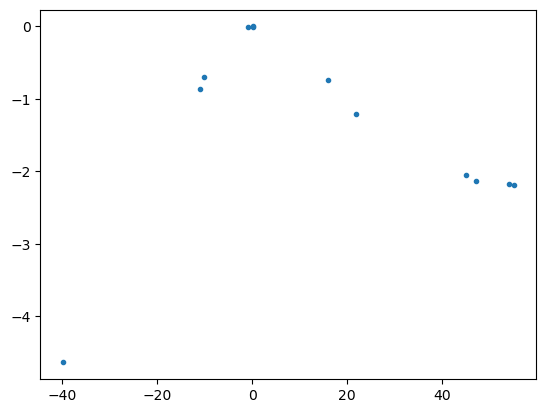

In [6]:
b = 'r'
data = sne[0][b]

x_peak = data['x_peak']
x = data['x']
y = data['y']
yerr = data['y']
m = data['m']
merr = data['merr']

mmax = np.min(m)

plt.plot(x - x_peak, mmax - m, '.')
# plt.plot(tt - x_peak, -m_func, '-')

In [7]:
t_bins = np.linspace(-50,100, 151)

In [8]:
dict_keys = [str(i) for i in t_bins[:-1]]

In [9]:
dat = {'Ib':{'u':{},
          'g':{},
          'r':{},
          'i':{}},
          'Ic':{'u':{},
          'g':{},
          'r':{},
          'i':{}},
          'Ic-bl':{'u':{},
          'g':{},
          'r':{},
          'i':{}}}
 
# iterating through the elements of list
for i in dict_keys:
    for key in dat.keys():
        dat[key]['u'][i] = [[],[]]
        dat[key]['g'][i] = [[],[]]
        dat[key]['r'][i] = [[],[]]
        dat[key]['i'][i] = [[],[]]

In [10]:
all_lc = {'Ib':{'u':[[],[]],
          'g':[[],[]],
          'r':[[],[]],
          'i':[[],[]]},
          'Ic':{'u':[[],[]],
          'g':[[],[]],
          'r':[[],[]],
          'i':[[],[]]},
          'Ic-bl':{'u':[[],[]],
          'g':[[],[]],
          'r':[[],[]],
          'i':[[],[]]}}



elasticc_sntype = {'Ib':['ELASTICC_TRAIN_SNIb+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIb-Templates/'],
                   'Ic':['ELASTICC_TRAIN_SNIc+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIc-Templates/'],
                   'Ic-bl':['ELASTICC_TRAIN_SNIcBL-+HostXT_V19/']}

SNTYPES_ = {'Ib':['Ib', 'Ibn'],
            'Ic':['Ic'],
            'Ic-bl':['Ic-bl']}

for sntype in list(elasticc_sntype.keys()):
    j_tmp = 0
        
    for i, path in enumerate(elasticc_sntype[sntype]):
        
        
        directory = lc_direc + path.split('/')[0] + '.pkl'
        sne = pkl.load(open(directory, "rb"))
        
        for j, key in enumerate(list(sne.keys())):
            data1 = sne[key]

            for b in data1.keys():

                data = data1[b]

                x_peak = data['x_peak']
                x = data['x']
                y = data['y']
                yerr = data['y']
                m = data['m']
                merr = data['merr']

                mmax = np.min(m)
                ind = (x - x_peak <20) & (x - x_peak >-20)
        
                xx = x[ind]

                tt = tt = np.linspace(xx.min(), xx.max(), 1000)

                if len(xx)<4:
                    continue

                interpld = interp1d(xx, m[ind], kind='cubic')(tt)

        #         if len(m_func[ind_ymin]) == 0:
        #             tot -= 1
        #             continue
                mmax = np.min(interpld)
                peak_adj = tt[np.argmin(interpld)]
                adj = peak_adj - x_peak
    
                x_ = x-x_peak
                y_ = mmax - m
        
                all_lc[sntype][b][0].append(x_-adj)
                all_lc[sntype][b][1].append(y_)
        
        


In [11]:
for sntype in all_lc.keys():
    for b in all_lc[sntype].keys():
        for bin_ in dat[sntype][b].keys():
            for i in range(len(all_lc[sntype][b][0])):
                if len(all_lc[sntype][b][0][i][(all_lc[sntype][b][0][i]>float(bin_)) &
                                       (all_lc[sntype][b][0][i]<float(bin_)+1)]) != 0:
                    dat[sntype][b][bin_][0] += list(all_lc[sntype][b][0][i][(all_lc[sntype][b][0][i]>float(bin_)) &
                                                           (all_lc[sntype][b][0][i]<float(bin_)+1)])
                    dat[sntype][b][bin_][1] += list(all_lc[sntype][b][1][i][(all_lc[sntype][b][0][i]>float(bin_)) &
                                                           (all_lc[sntype][b][0][i]<float(bin_)+1)])

In [12]:
meds_t = t_bins[:-1] + 0.5
meds = {'Ib':[[], [], [], []],
        'Ic':[[], [], [], []],
        'Ic-bl':[[], [], [], []]}

for sntype in dat.keys():
    for i, b in enumerate(dat[sntype].keys()):
        for key in dat[sntype][b].keys():
            if len(dat[sntype][b][key][1]) == 0:
                meds[sntype][i].append(np.nan)
            else:
                meds[sntype][i].append(np.median(dat[sntype][b][key][1]))


KeyError: 'Ib'

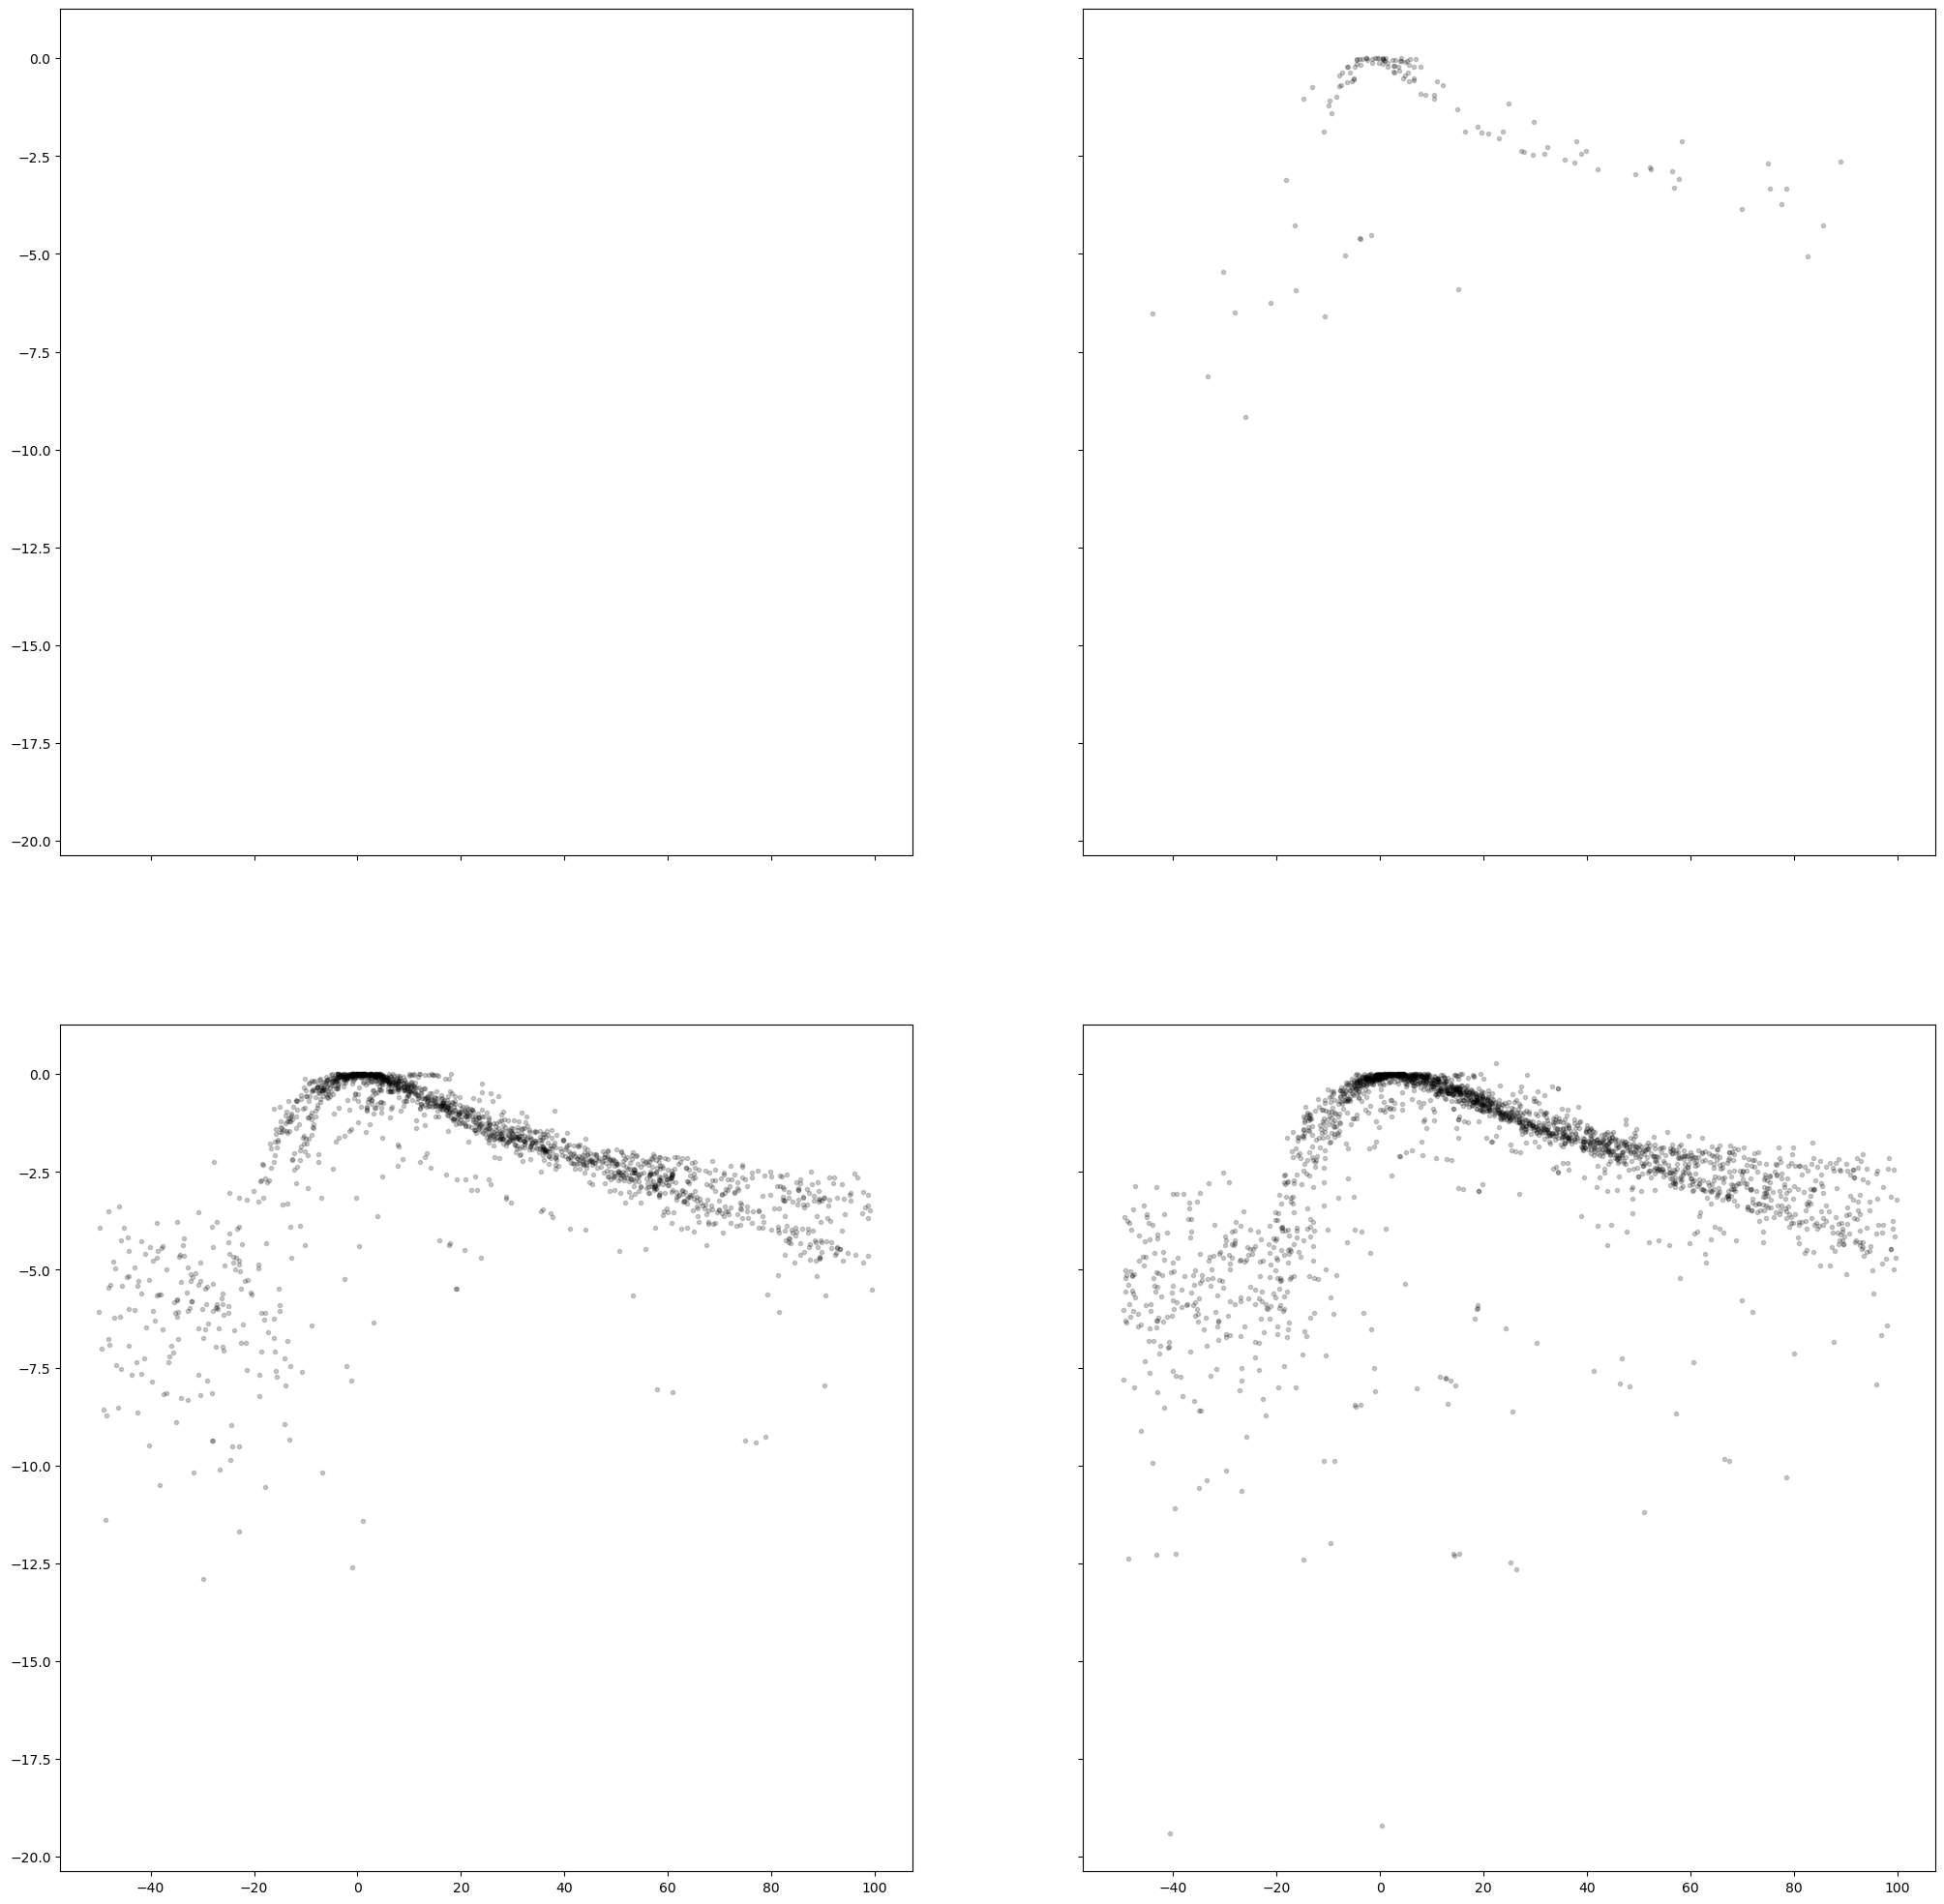

In [13]:
bb = ['u ', 'g ', 'r ', 'i ']
b_index = {'u':0,
           'g':1,
           'r':2,
           'i':3}

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))

for j, key in enumerate(list(sne.keys())):
    data1 = sne[key]
    
    for b in data1.keys():
        
        data = data1[b]

        x_peak = data['x_peak']
        x = data['x']
        y = data['y']
        yerr = data['y']
        m = data['m']
        merr = data['merr']
        
        mmax = np.min(m)
        
        ind = (x - x_peak <20) & (x - x_peak >-20)
        
        xx = x[ind]
        
        tt = tt = np.linspace(xx.min(), xx.max(), 1000)
        
        if len(xx)<4:
            continue
        
        interpld = interp1d(xx, m[ind], kind='cubic')(tt)

#         if len(m_func[ind_ymin]) == 0:
#             tot -= 1
#             continue
        mmax = np.min(interpld)

        

        np.concatenate(ax)[b_index[b.strip()]].plot(x-x_peak, mmax - m , 'k.', alpha=0.2)
#         np.concatenate(ax)[b_index[b.strip()]].plot(tt-x_peak, mmax - interpld , 'k-', alpha = 0.2)

for i, b in enumerate(dat.keys()):
    np.concatenate(ax)[b_index[b]].plot(meds_t, meds[i], '.-', markersize = 20, color = 'purple')
    

plt.xlim(-50, 100)
plt.ylim(-4, 1)


Ib


/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_71862/1245695471.py:174: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_71862/1245695471.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


Ib
Ic
Ic
Ic-bl
Ic-bl


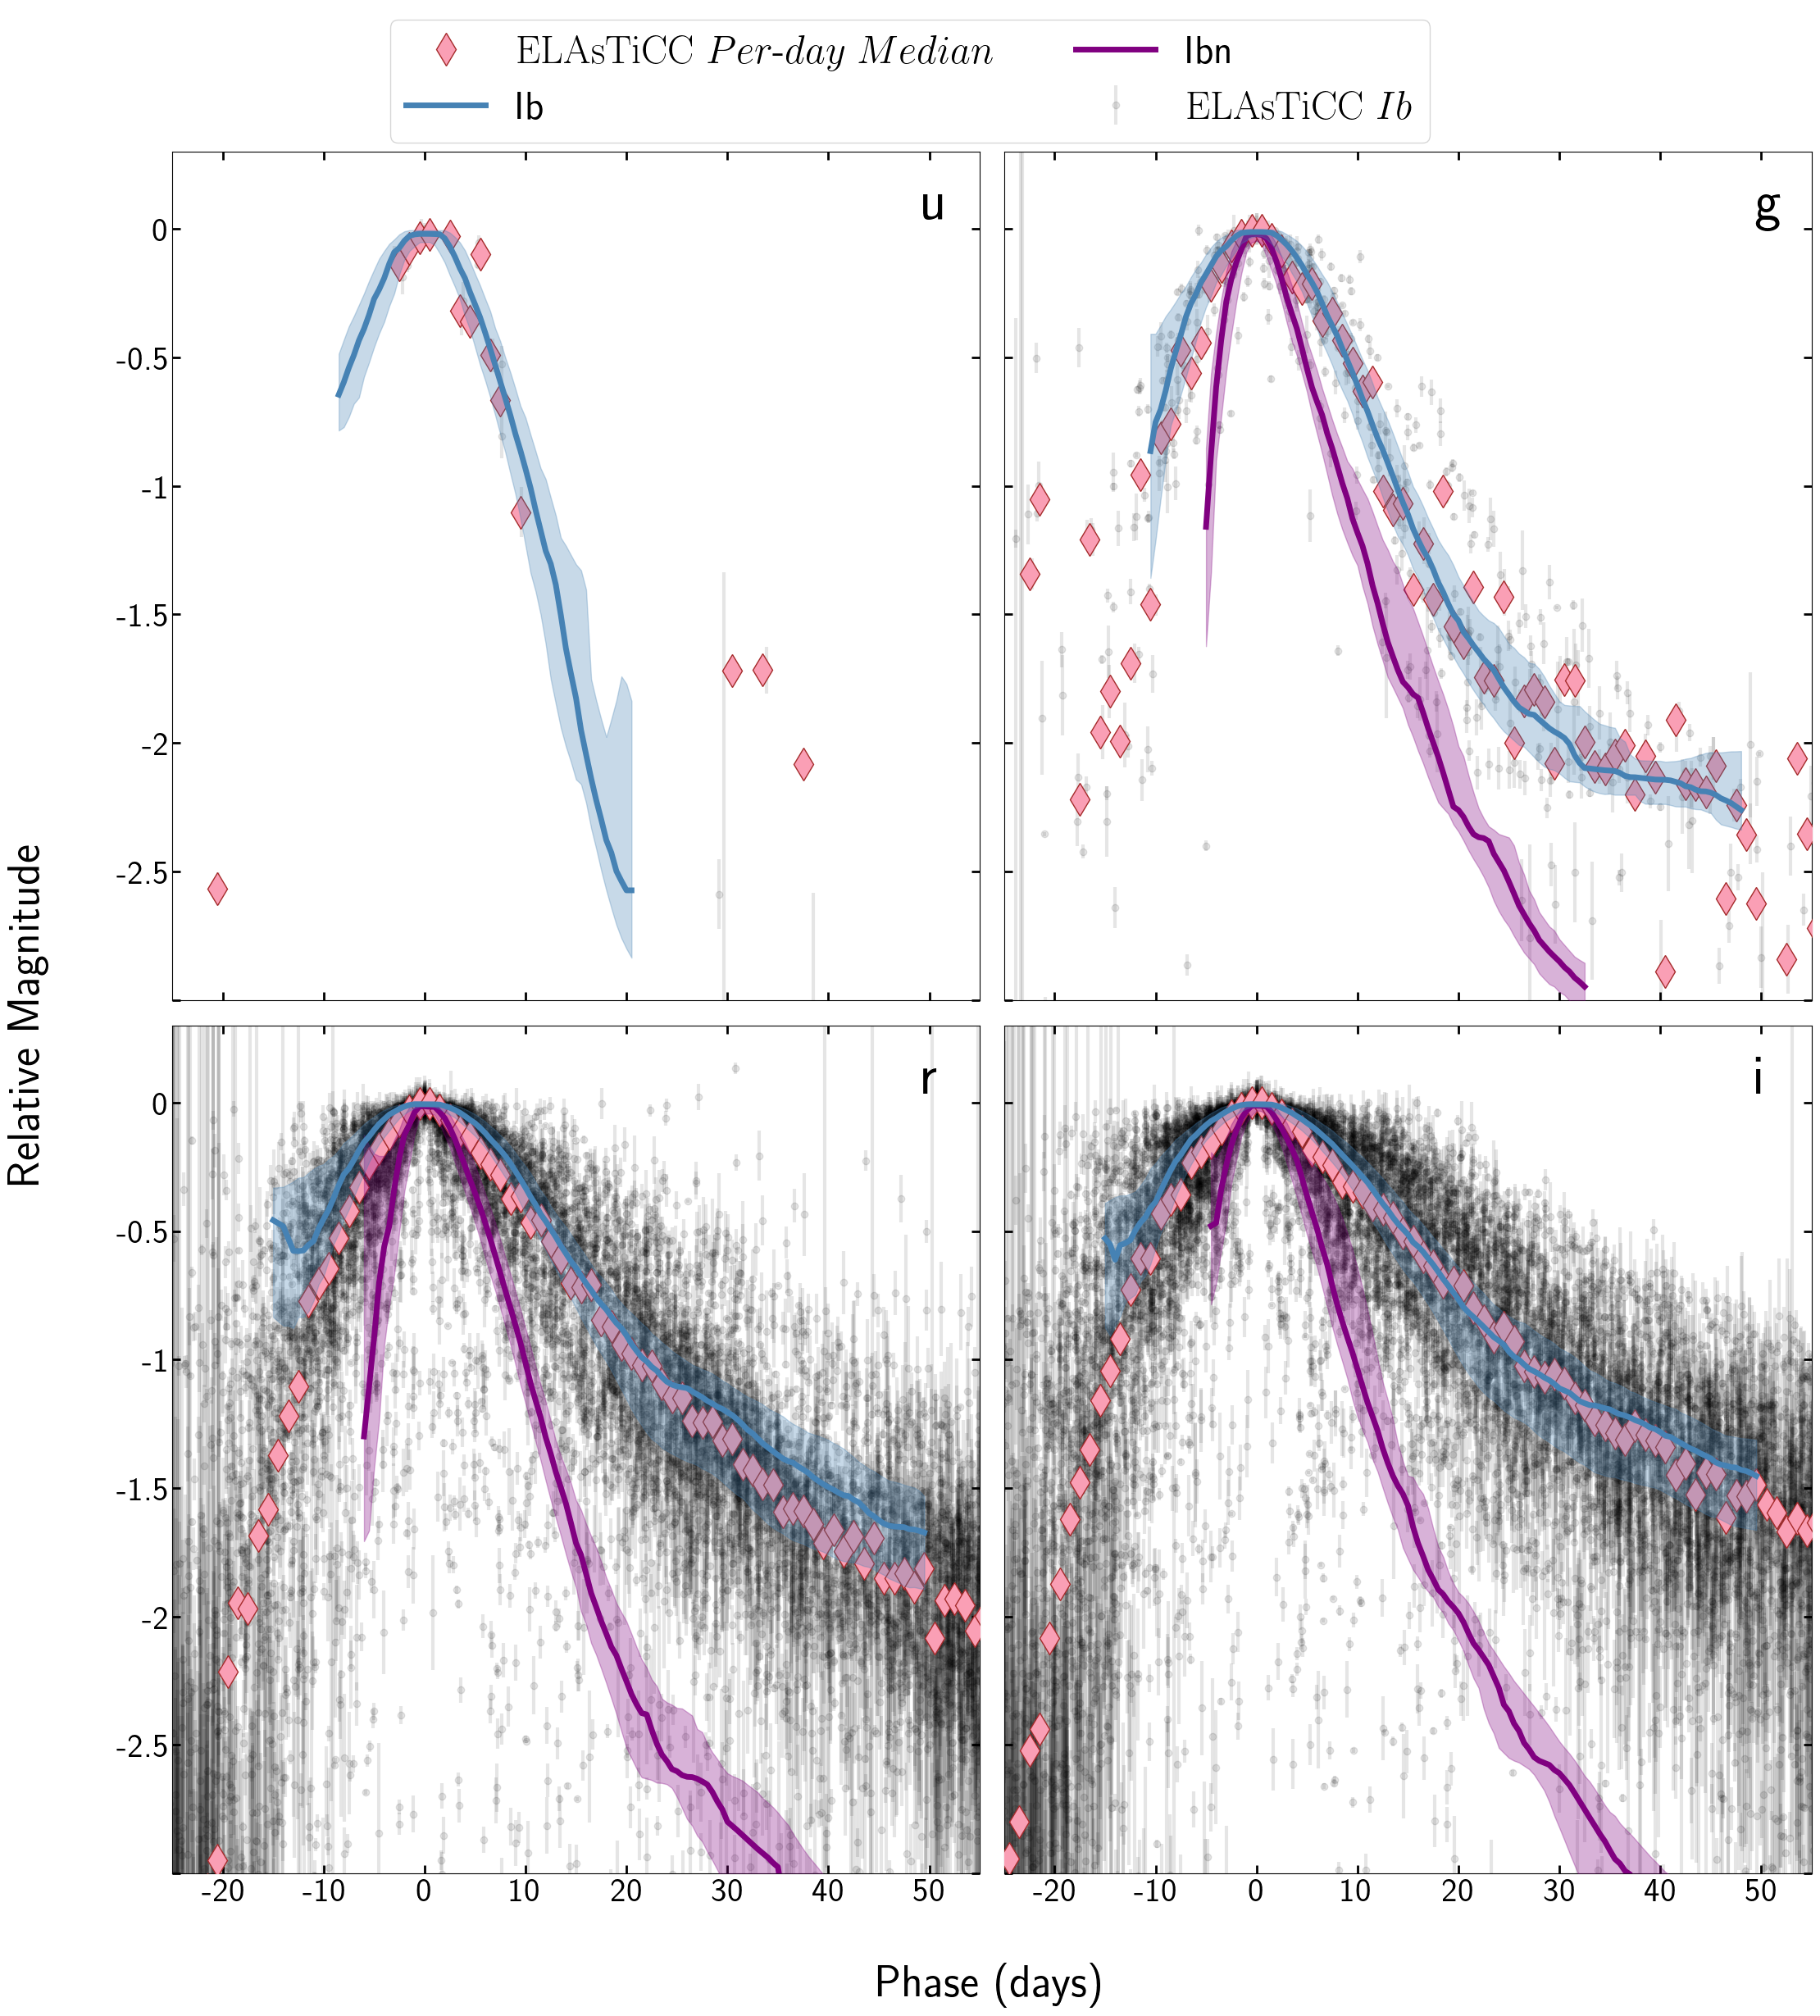

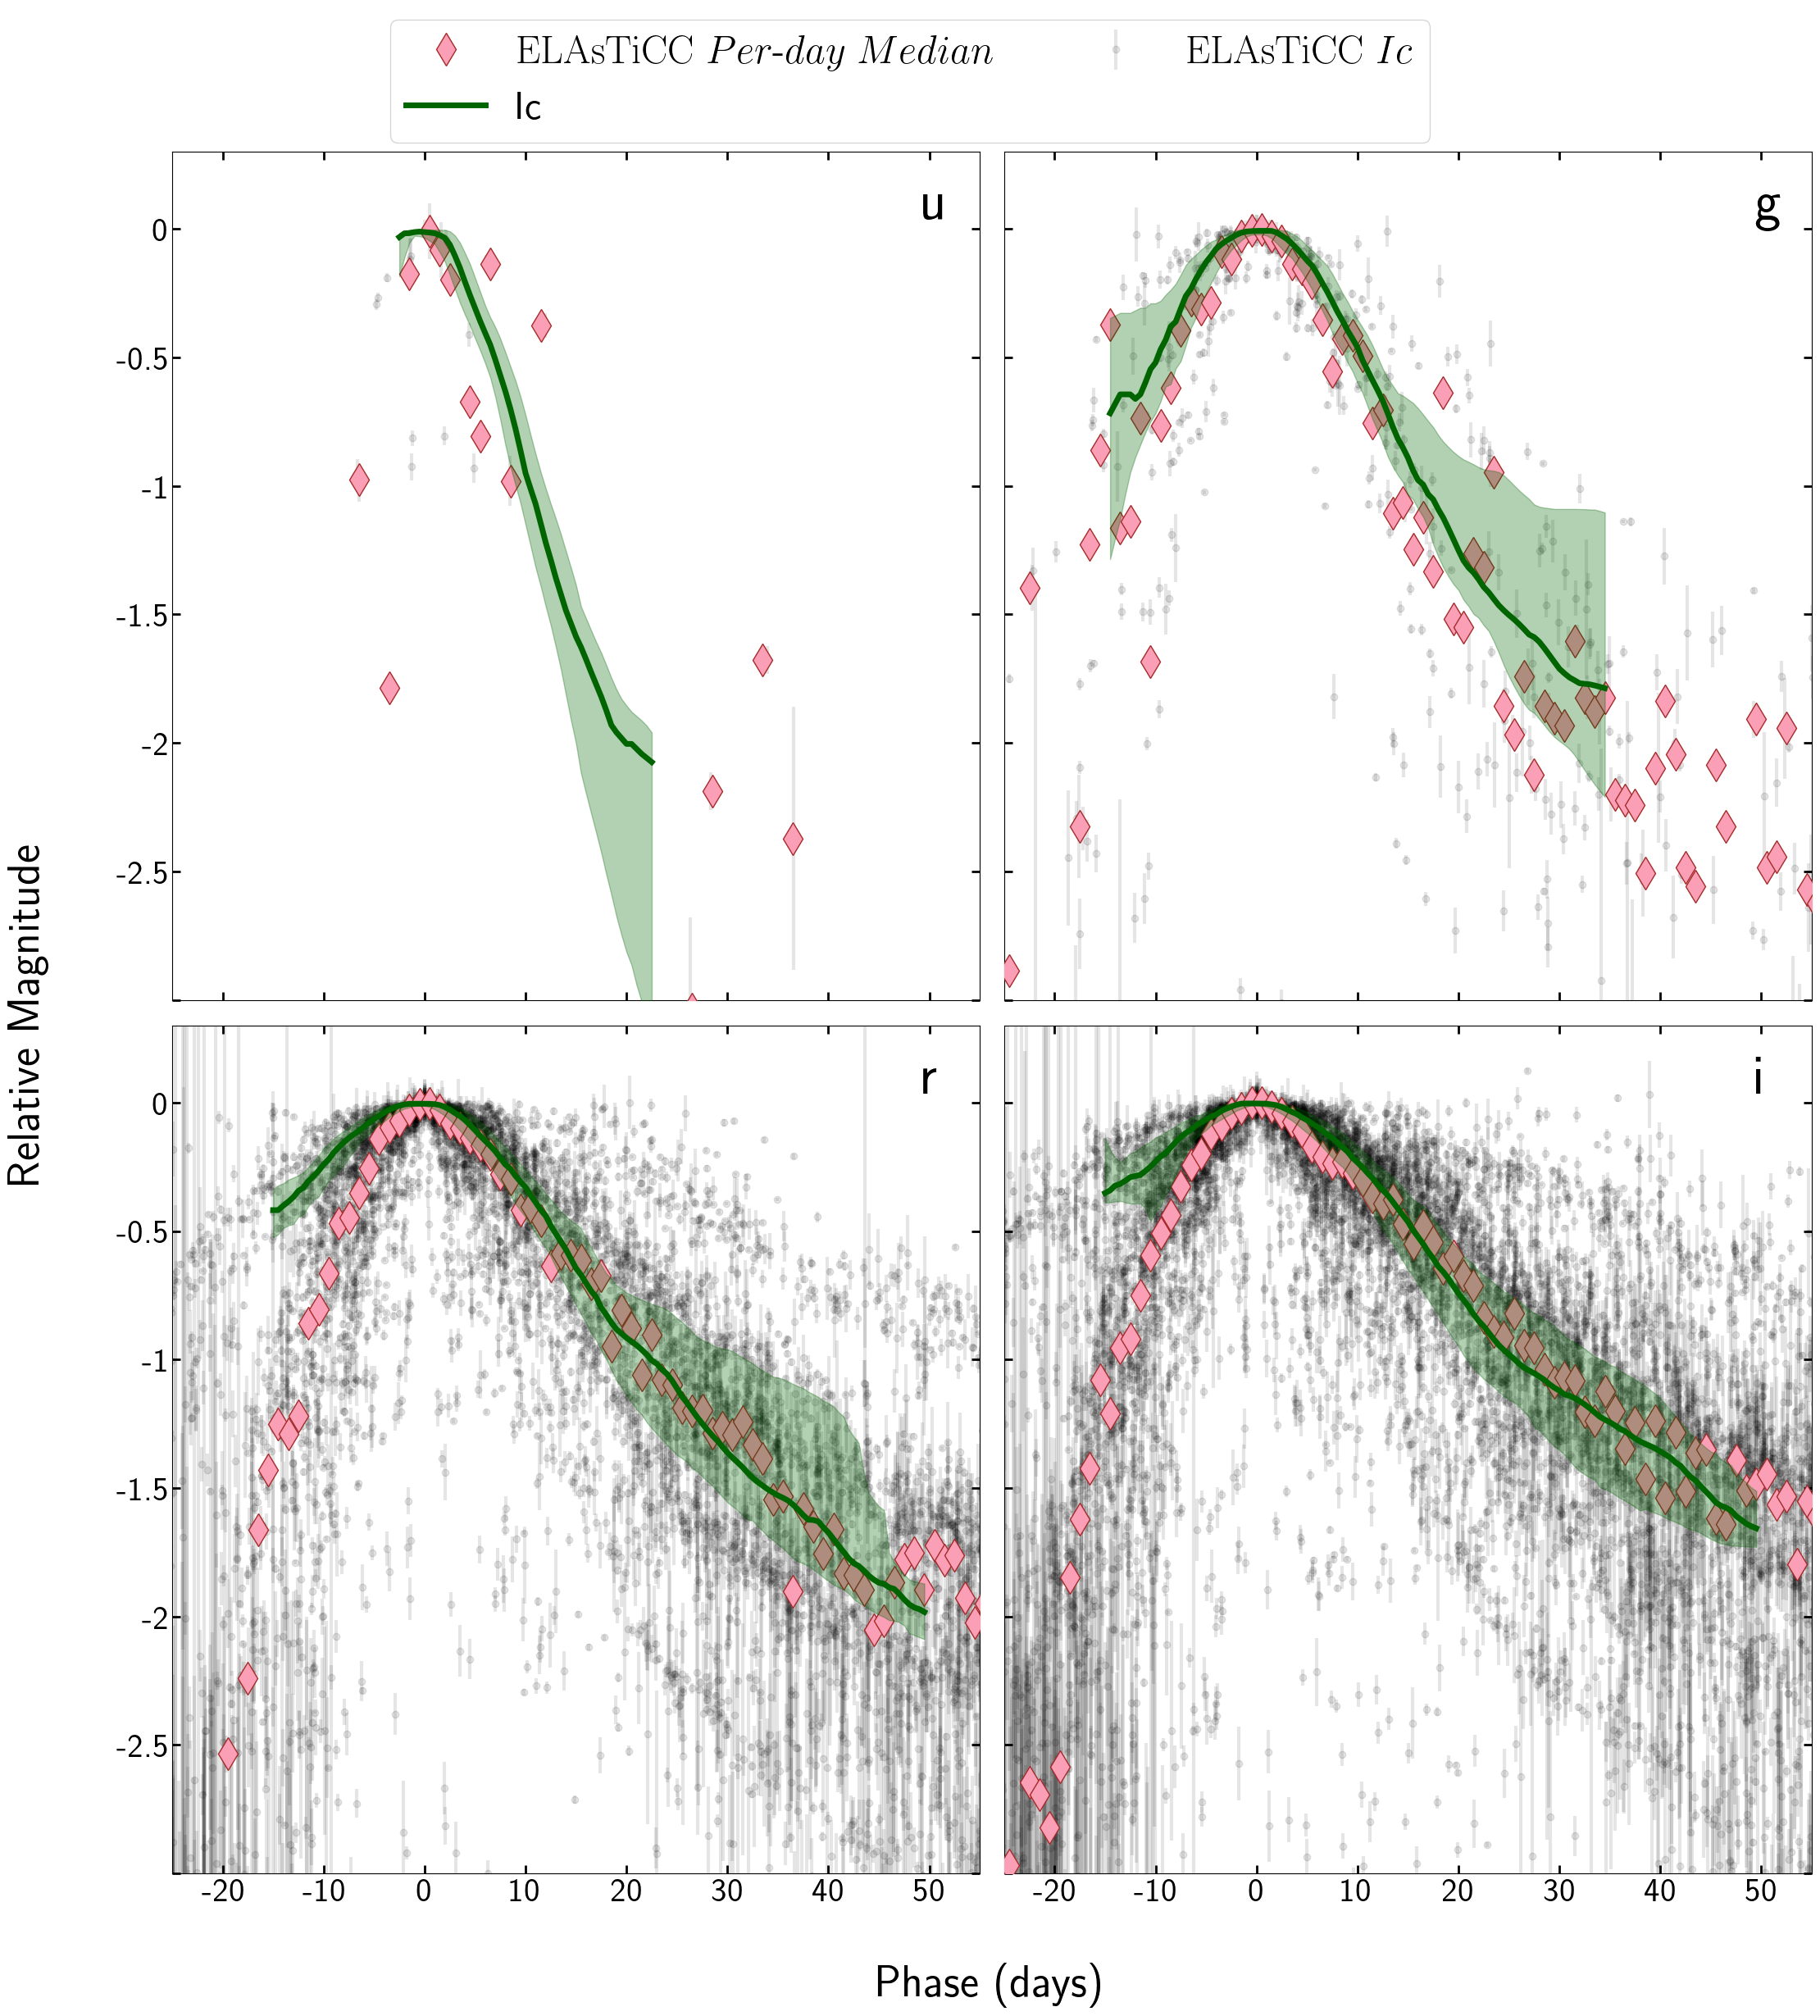

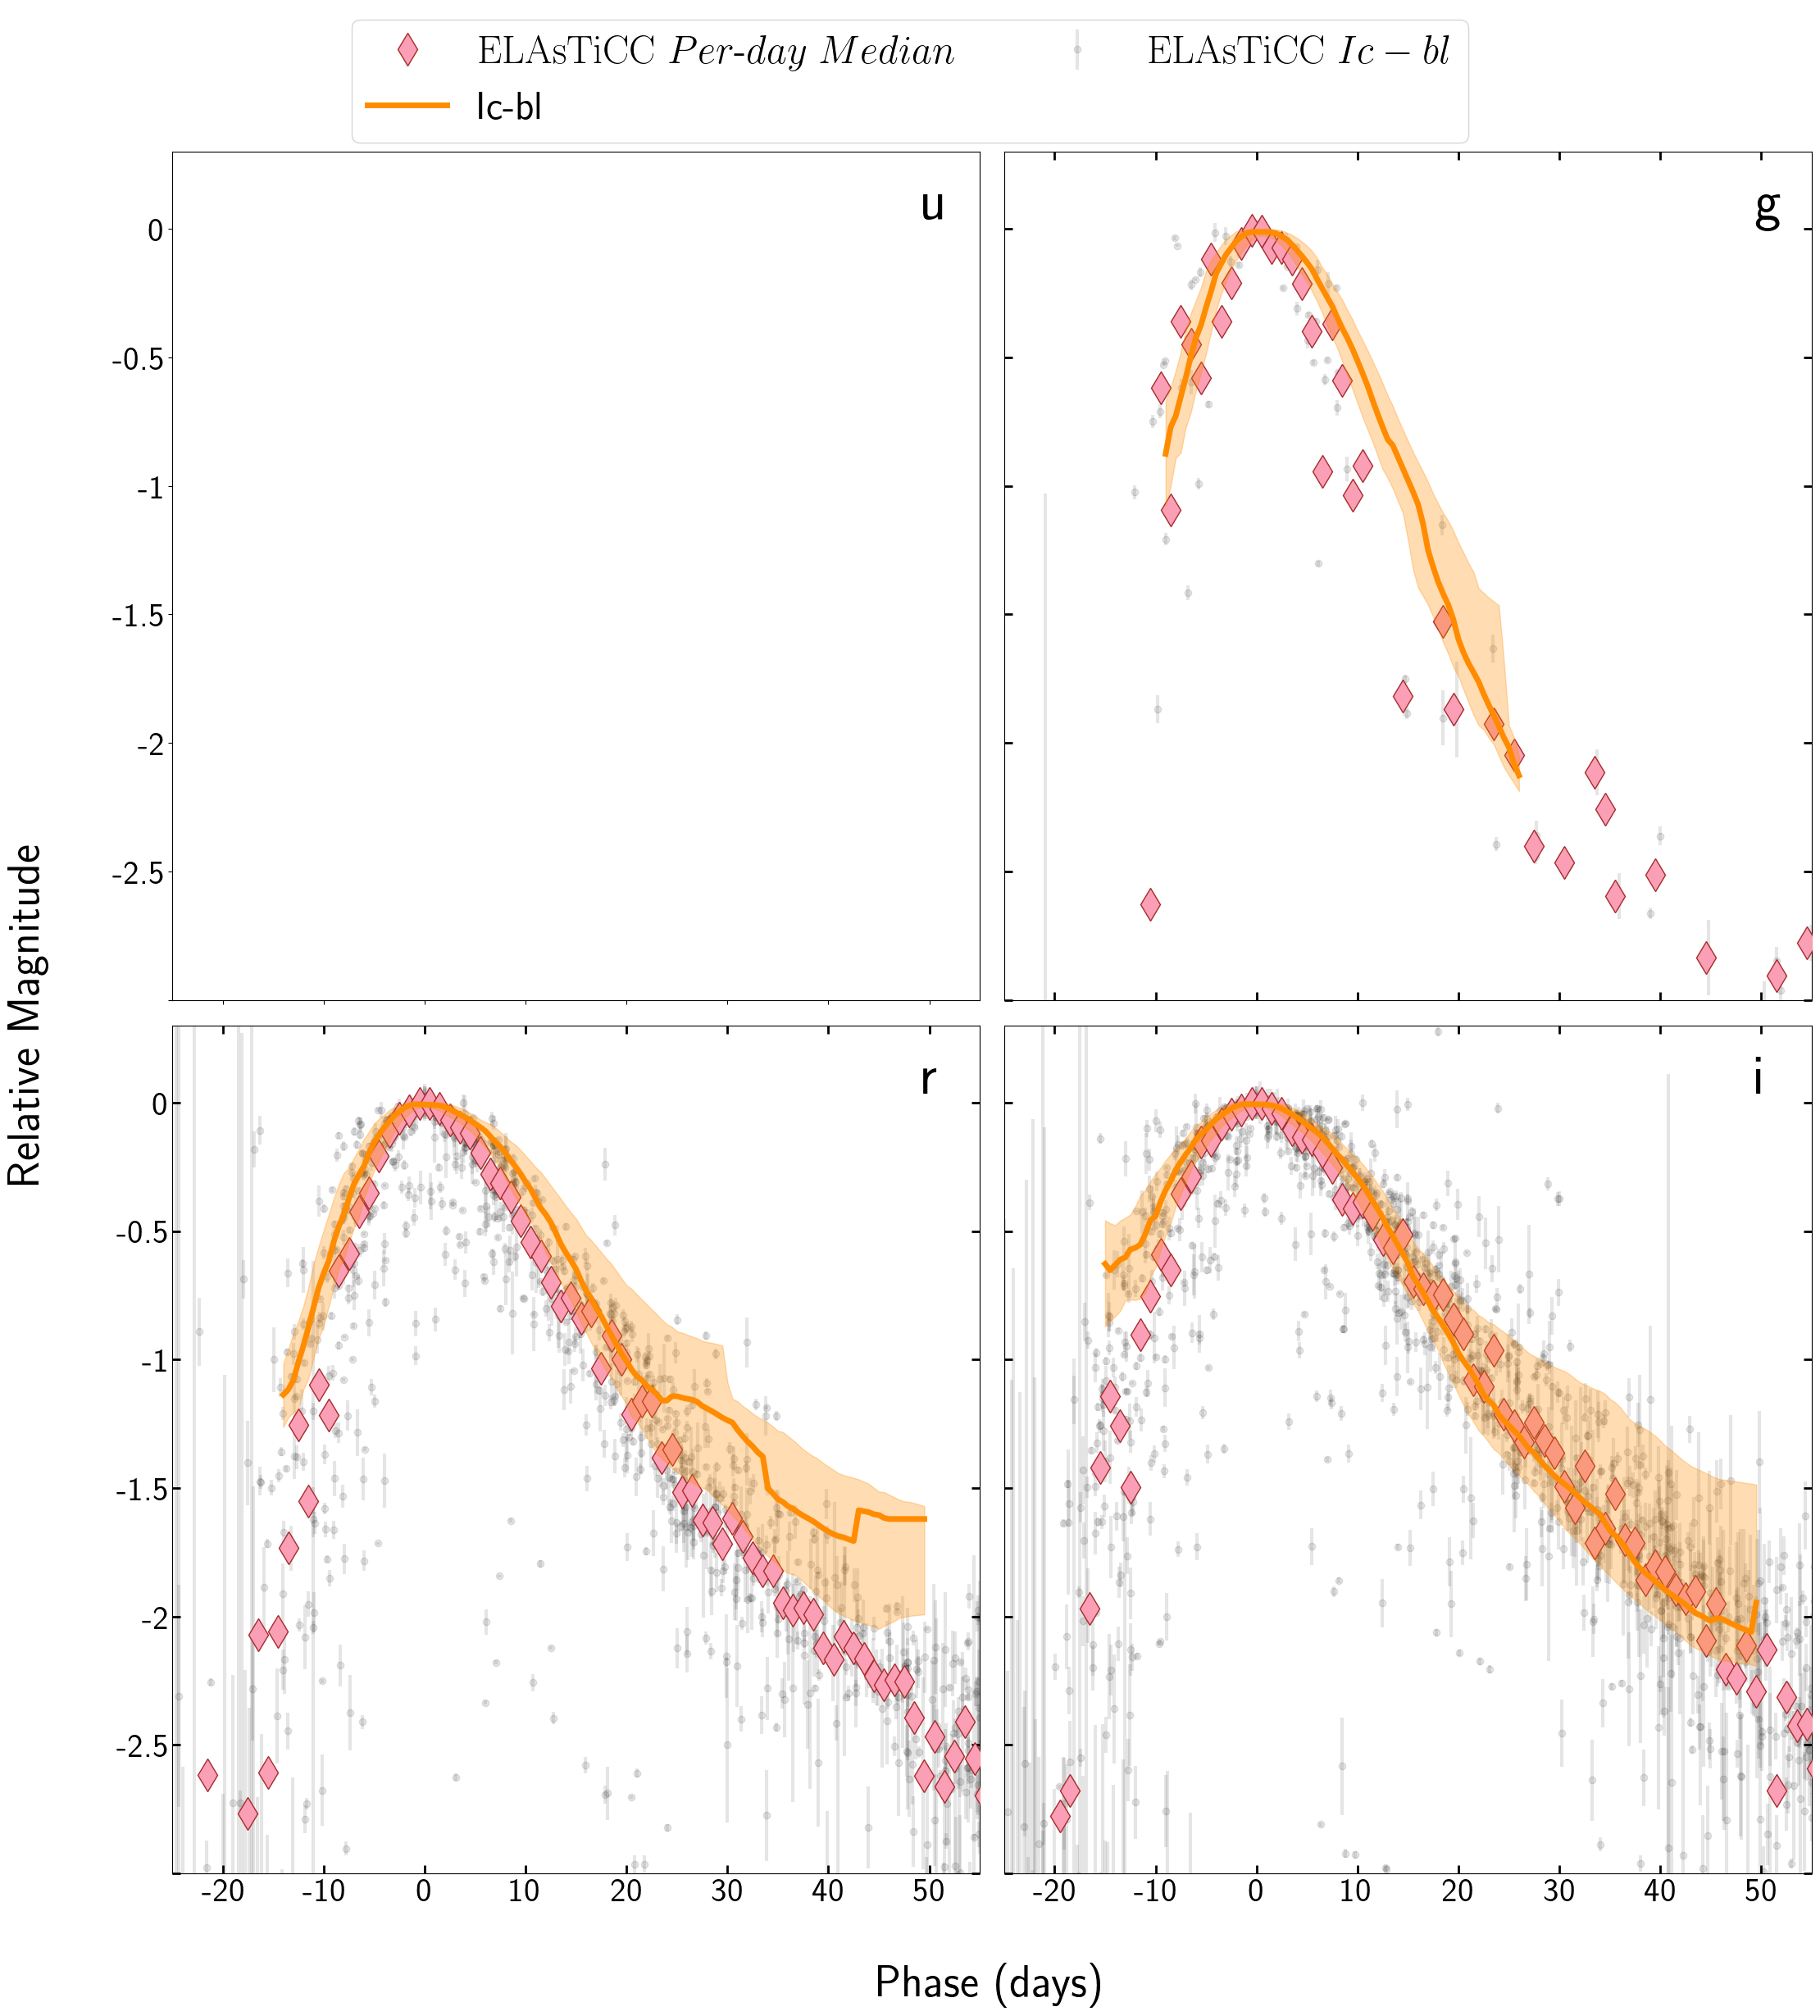

In [18]:
# ugrizy = 012345
bb = ['u','g','r','i']
b_ = [0,1,2,3]



# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
elasticc_sntype = {'Ib':['ELASTICC_TRAIN_SNIb+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIb-Templates/'],
                   'Ic':['ELASTICC_TRAIN_SNIc+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIc-Templates/'],
                   'Ic-bl':['ELASTICC_TRAIN_SNIcBL-+HostXT_V19/']}

SNTYPES_ = {'Ib':['Ib', 'Ibn'],
            'Ic':['Ic'],
            'Ic-bl':['Ic-bl']}

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)

elasticc_lc = {}
    
for sntype in list(elasticc_sntype.keys()):
    elasticc_lc[sntype] = {}
    elasticc_lc[sntype]['per_day_med'] = {}
    j_tmp = 0
    print(sntype)
    
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))
    
    for i, path in enumerate(elasticc_sntype[sntype]):
        
        
        directory = lc_direc + path.split('/')[0] + '.pkl'
        sne = pkl.load(open(directory, "rb"))
        
        for j, key in enumerate(list(sne.keys())):
            data1 = sne[key]
            elasticc_lc[sntype][key]={}

            for b in data1.keys():

                data = data1[b]

                x_peak = data['x_peak']
                x = data['x']
                y = data['y']
                yerr = data['y']
                m = data['m']
                merr = data['merr']

                mmax = np.min(m)
                ind = (x - x_peak <20) & (x - x_peak >-20)
        
                xx = x[ind]

                tt = tt = np.linspace(xx.min(), xx.max(), 1000)

                if len(xx)<4:
                    continue

                interpld = interp1d(xx, m[ind], kind='cubic')(tt)

        #         if len(m_func[ind_ymin]) == 0:
        #             tot -= 1
        #             continue
                mmax = np.min(interpld)
                peak_adj = tt[np.argmin(interpld)]
                adj = peak_adj - x_peak
                
                elasticc_lc[sntype][key][b]={}
                elasticc_lc[sntype][key][b]['phs'] = x - x_peak - adj
                elasticc_lc[sntype][key][b]['mag'] = mmax - m
                elasticc_lc[sntype][key][b]['err'] = merr

                if i == 0 and b == 'r' and j_tmp == 0:
                    j_tmp = 1
                    np.concatenate(ax)[b_index[b]].errorbar(x - x_peak - adj,\
                        mmax - m , yerr=merr, fmt='o',\
                        linewidth = 3, color = 'k',
                        label = r'$\mathrm{ELAsTiCC }\;$'+'$'+sntype+'$', alpha = 0.1)
        #             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
        #                 new_y_peak - m_func,\
        #                 '-', linewidth = 0.1, color = 'k', alpha = 0.1, label = 'VL fit')


                else:
                    np.concatenate(ax)[b_index[b]].errorbar(x - x_peak-adj,\
                        mmax - m , yerr=merr, fmt='o',\
                        linewidth = 3, color = 'k', alpha = 0.1)
        #             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
        #                 new_y_peak - m_func,\
        #                 '-', linewidth = 0.1, color = 'k', alpha = 0.1)


    for j, b in enumerate(bb):
        
        elasticc_lc[sntype]['per_day_med'][b] = {}
        elasticc_lc[sntype]['per_day_med'][b]['med_t'] = meds_t
        elasticc_lc[sntype]['per_day_med'][b]['med'] = meds[sntype][j]
        
        
        if b == 'r':
            np.concatenate(ax)[b_index[b]].plot(meds_t, meds[sntype][j], "d",
                                            markersize = 20, color = '#fa9fb5',
                                           markeredgecolor='brown', zorder=10,
                                               label = r'$\mathrm{ELAsTiCC }\; Per$-$day\; Median$')
        else:
            np.concatenate(ax)[b_index[b]].plot(meds_t, meds[sntype][j], "d",
                                            markersize = 20, color = '#fa9fb5',
                                           markeredgecolor='brown', zorder=10)

        for tp in SNTYPES_[sntype]:

            if tp != sntype:
                alpha = 1
                zorder = 15
            else:
                alpha = 1
                zorder = 19

            if len(tmpl[b][tp]) == 0:
                continue

            if b == 'r':

                np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],
                        tmpl[b][tp]['rollingMedian'],
                        '-',color = colorTypes[tp], alpha = alpha,
                        linewidth=5, zorder = zorder, label = tp)
                np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                        tmpl[b][tp]['rollingPc25'],\
                        tmpl[b][tp]['rollingPc75'],\
                        alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)

            else:


                if b == 'g' and tp == 'Ic':

                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingMedian'][tmpl[b][tp]['t']<35],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc25'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc75'][tmpl[b][tp]['t']<35],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)
                else:
                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingMedian'],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingPc25'],\
                            tmpl[b][tp]['rollingPc75'],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)

            np.concatenate(ax)[b_[j]].tick_params(axis="both", direction="in", which="major",\
                                                  right=True, top=True, size=7, labelsize=25, width = 2)

        np.concatenate(ax)[b_[j]].text(0.93, 0.92, b, transform=np.concatenate(ax)[b_[j]].transAxes,\
                                   weight='bold', size = 50, color = 'k')

    handles, labels = np.concatenate(ax)[2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, prop={'size':35})
    np.concatenate(ax)[0].set_xlim(-25,55)
    np.concatenate(ax)[0].set_ylim(-3,0.3)
    np.concatenate(ax)[0].set_yticks([0, -0.5, -1, -1.5, -2, -2.5, -3])
    np.concatenate(ax)[0].set_yticklabels([ '0','-0.5',  '-1', '-1.5', '-2', '-2.5', ''], size=30)
    np.concatenate(ax)[2].set_yticklabels(['0','-0.5',  '-1', '-1.5', '-2', '-2.5', ''], size=30)

    np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
    np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)



    plt.subplots_adjust(hspace=.03, wspace=0.03, top = 0.92, left = 0.1, bottom = 0.08)

    fig.text(0.5, 0.02, 'Phase (days)', ha='center', size = 40)
    fig.text(0.02, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)

    print(sntype)
#     plt.savefig('Elasticc_lc_type_'+ sntype + '_cubic_interpol_median_elasticc.pdf',
#                 bbox_inches='tight')

In [20]:

file = open('./../share_tmpls/elasticc.pkl', 'wb')
pkl.dump(elasticc_lc, file)

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_71862/177327504.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_71862/177327504.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


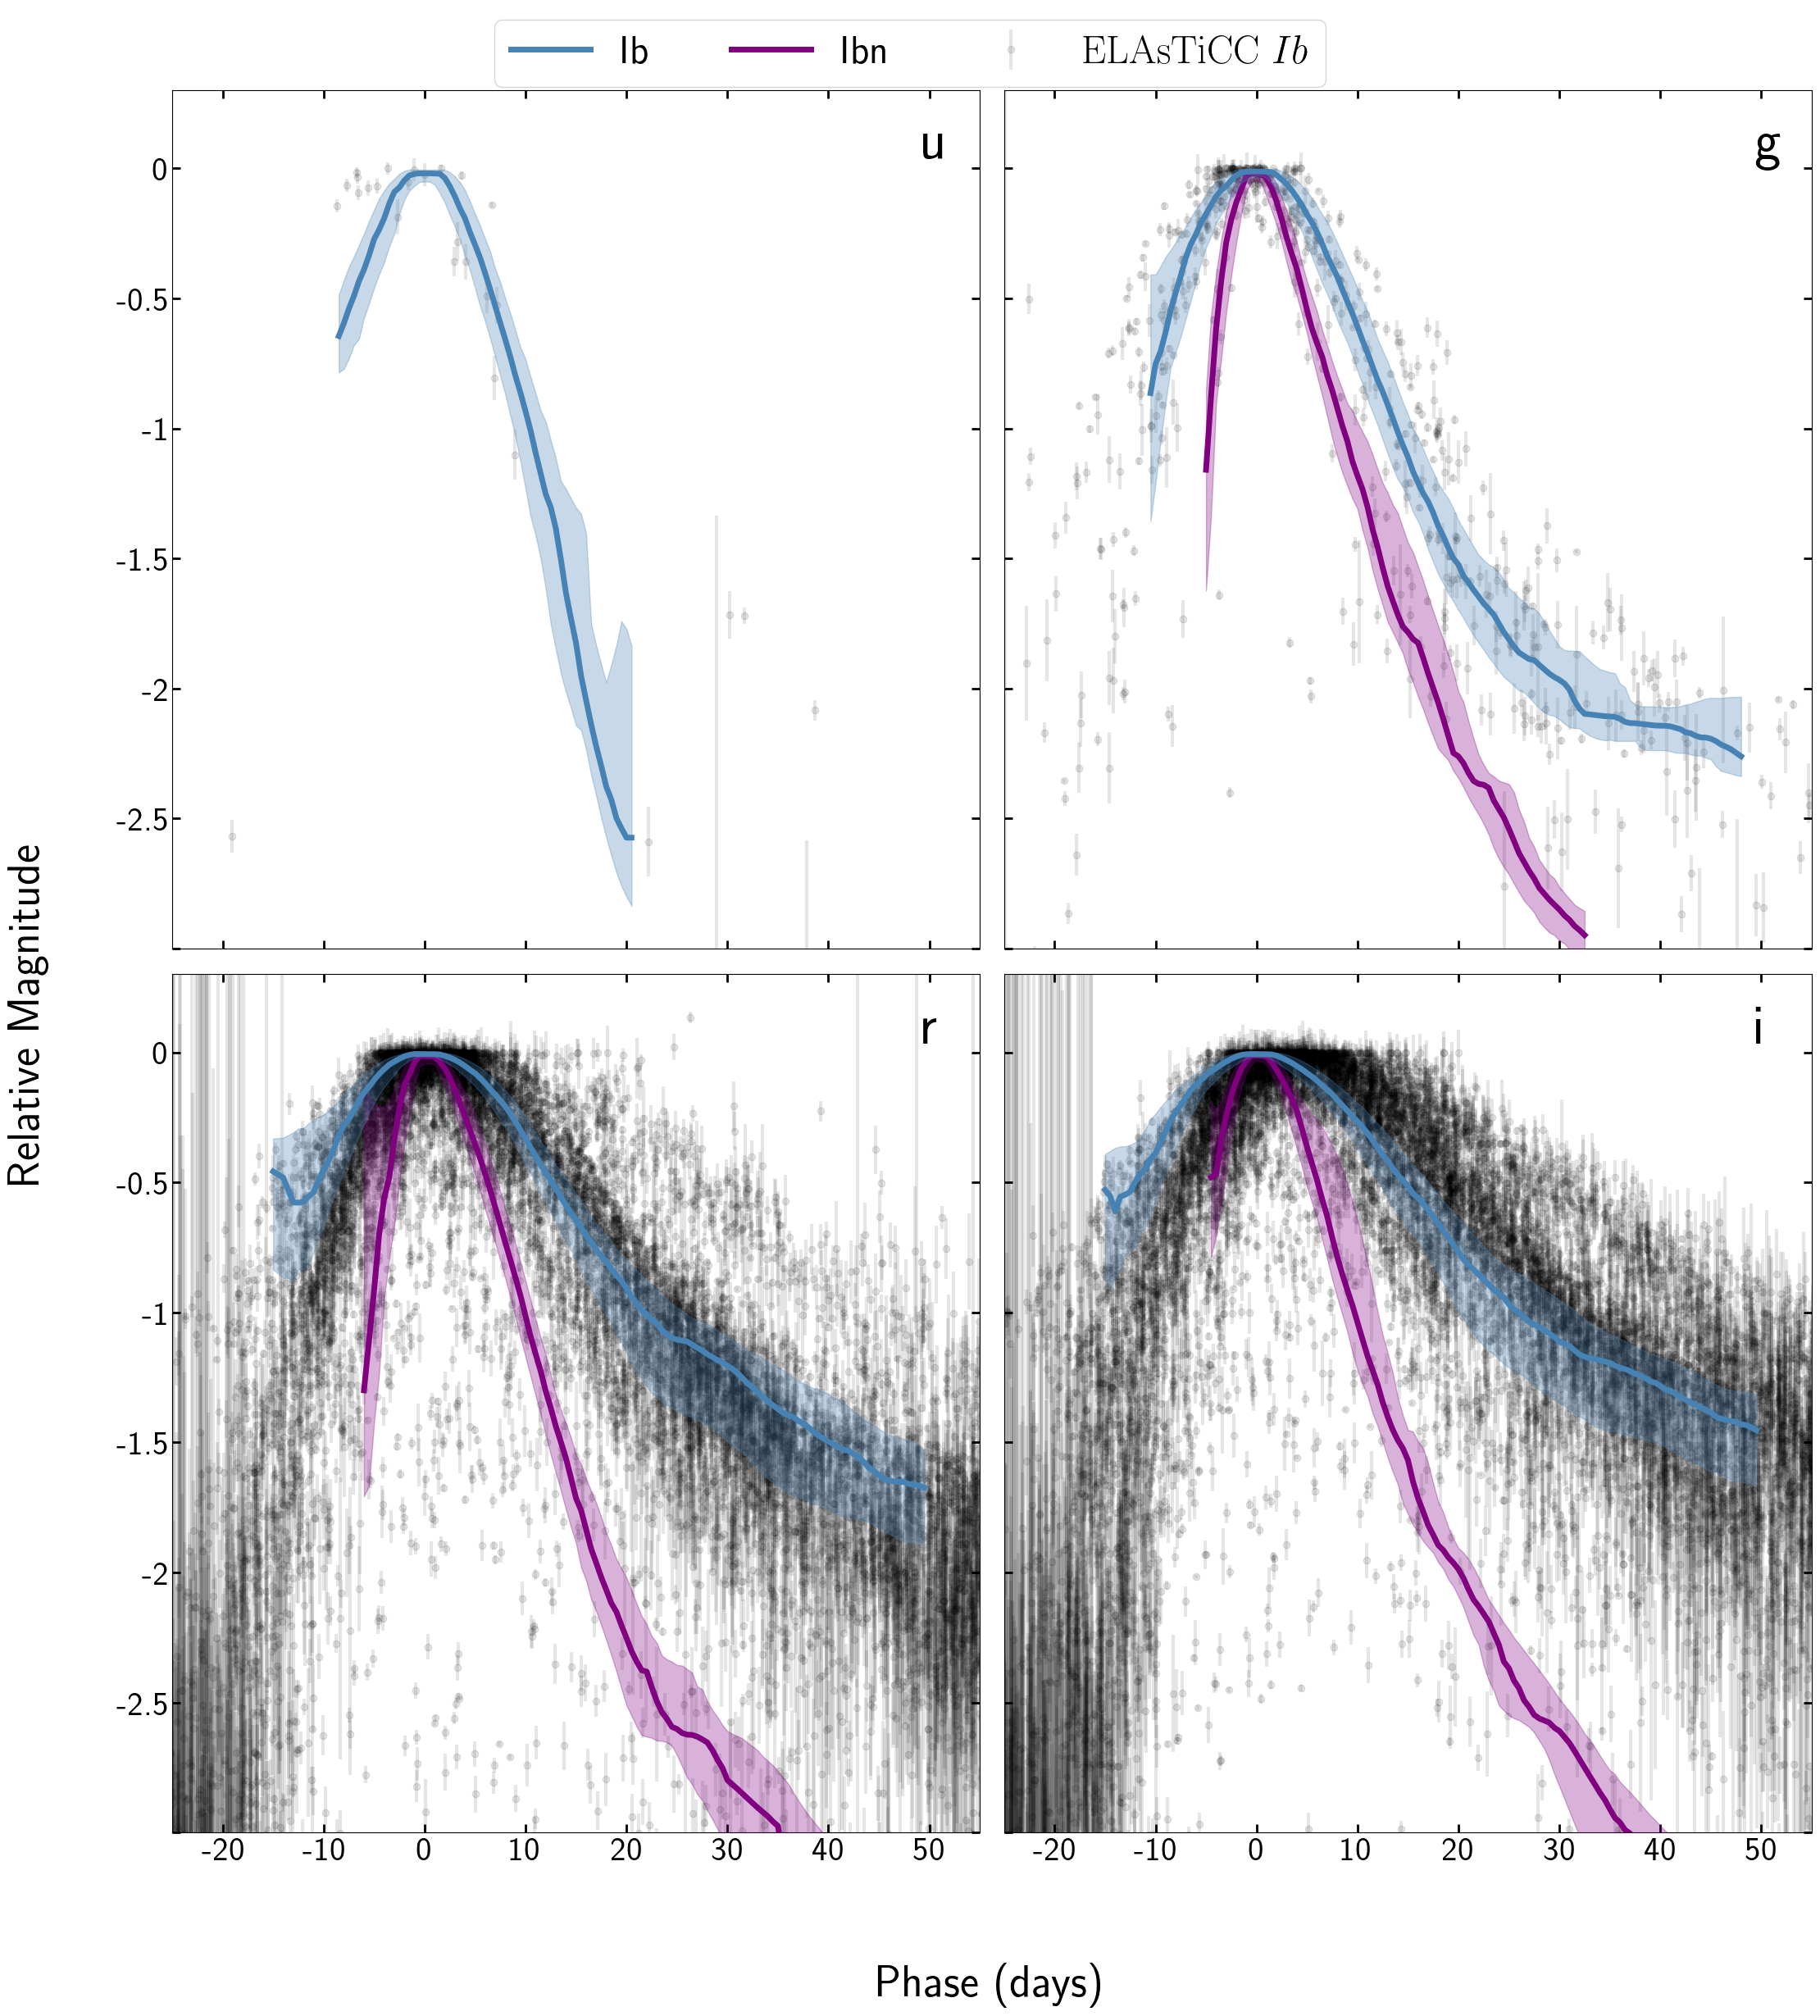

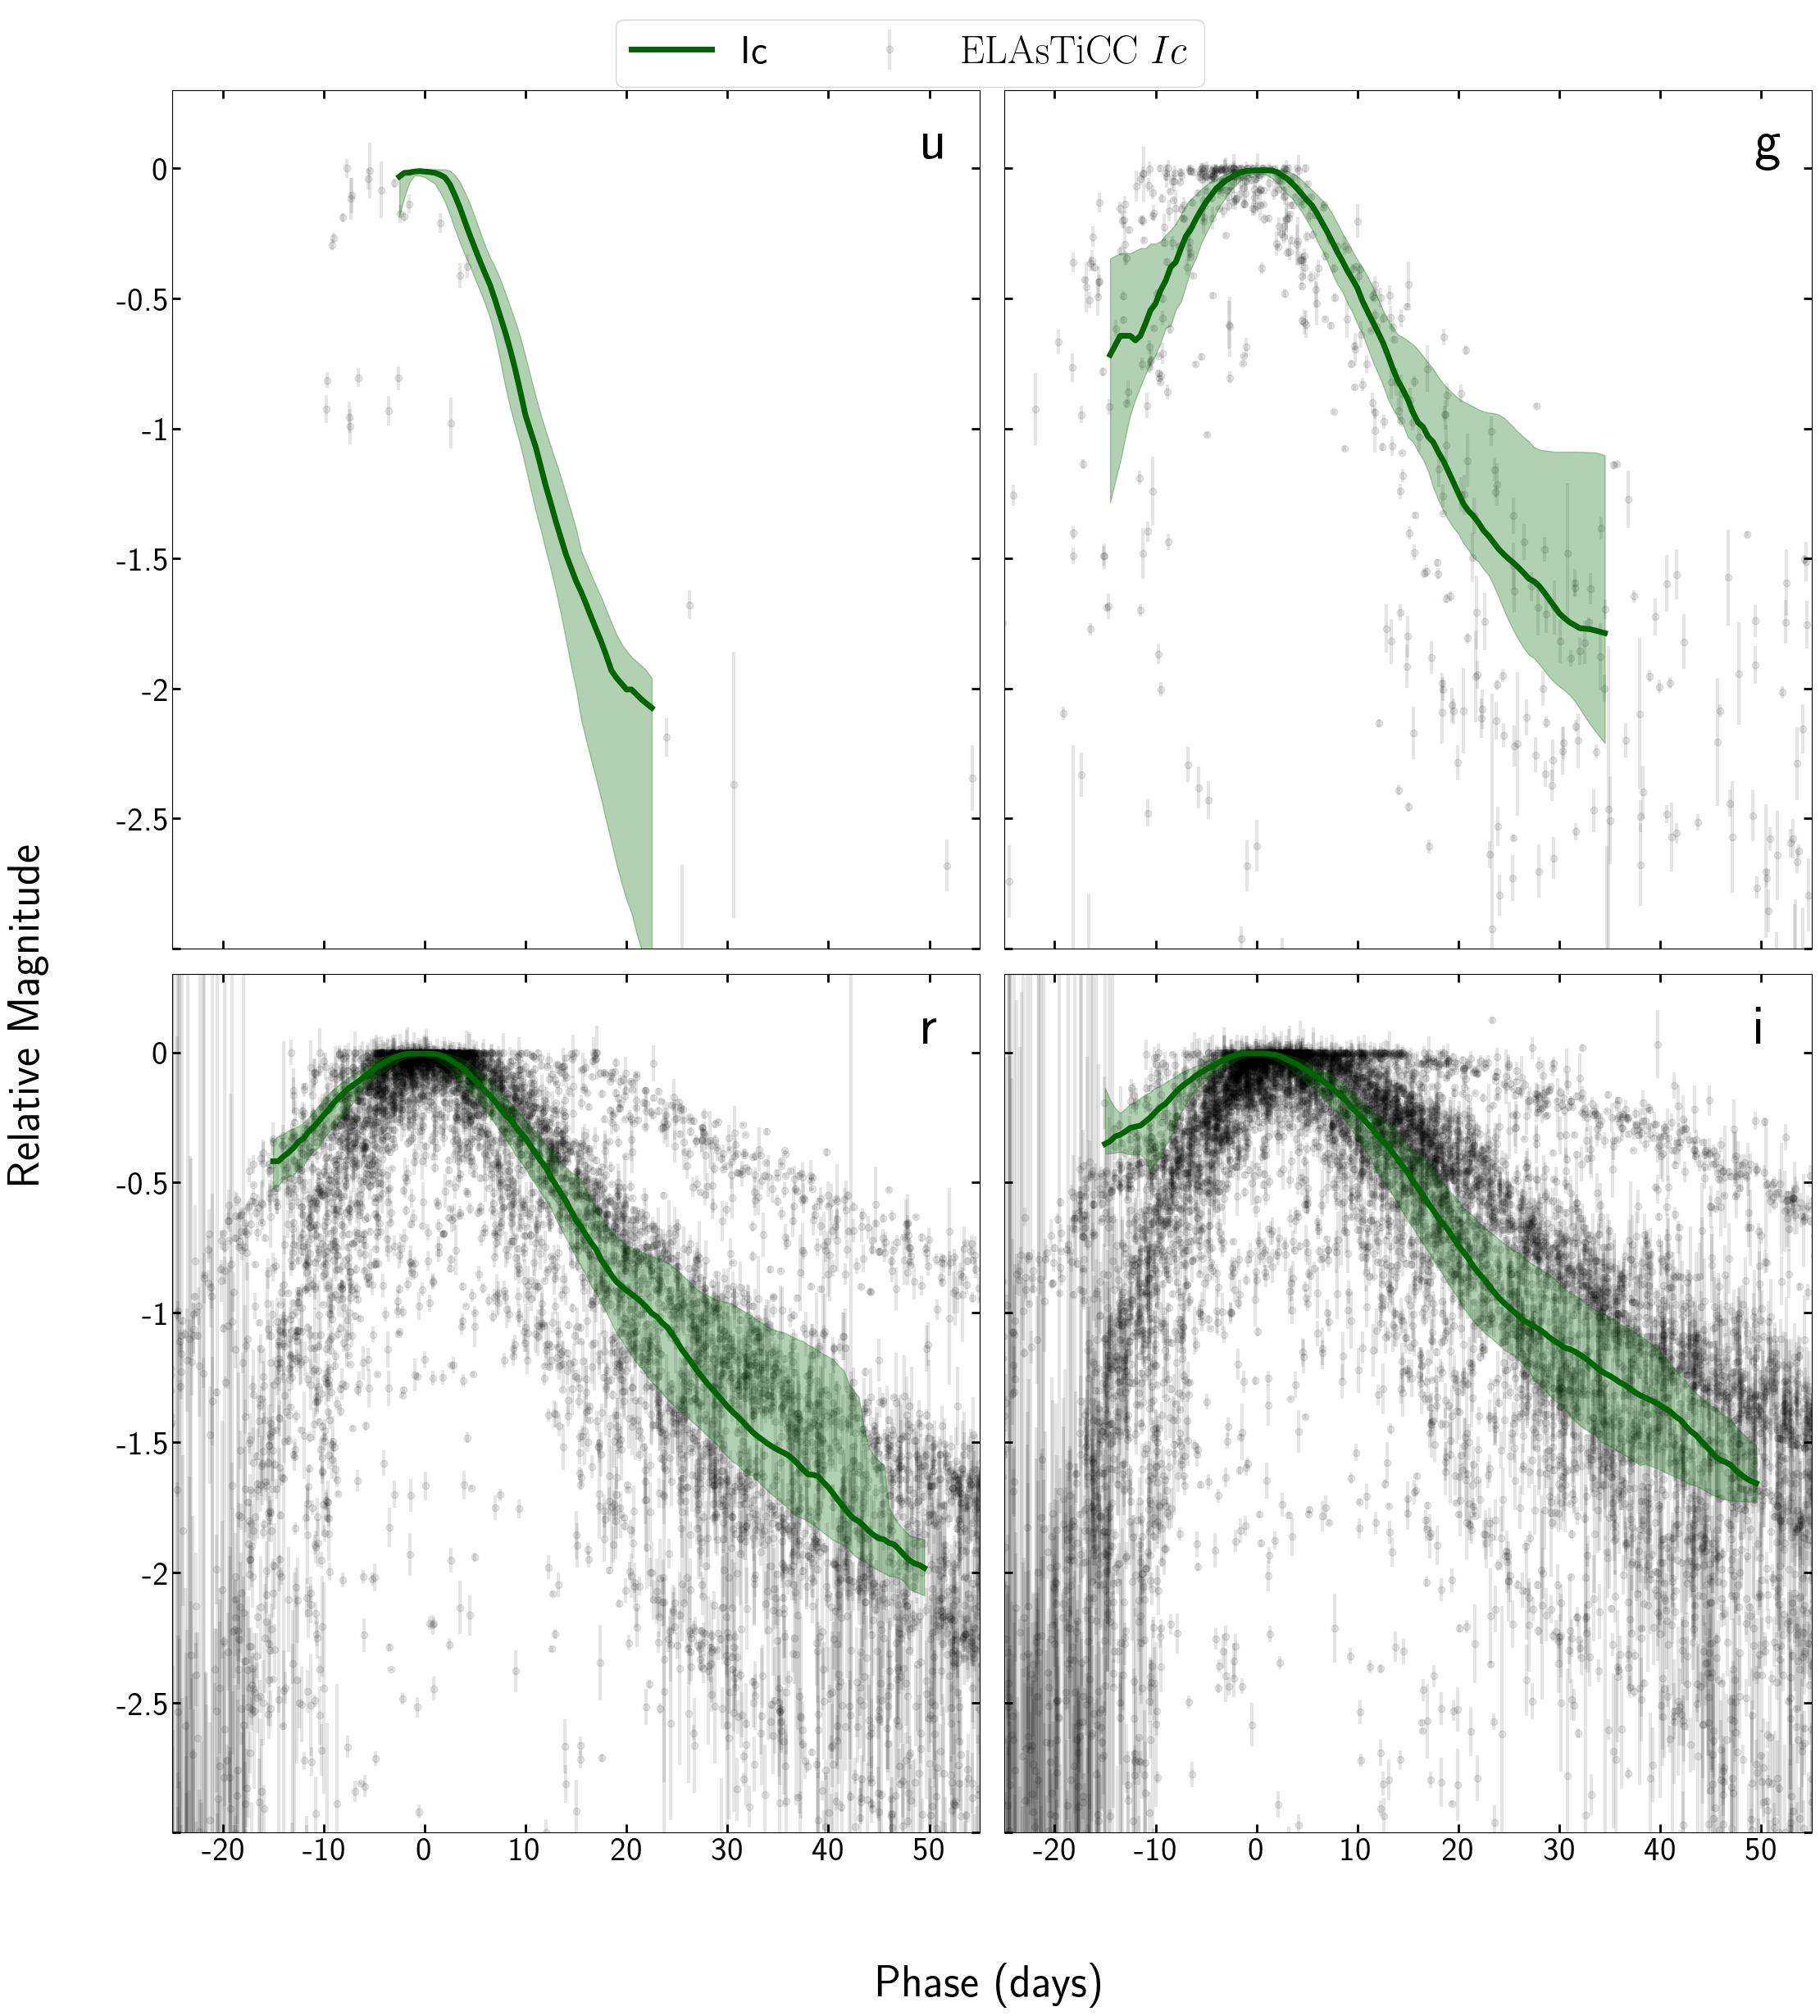

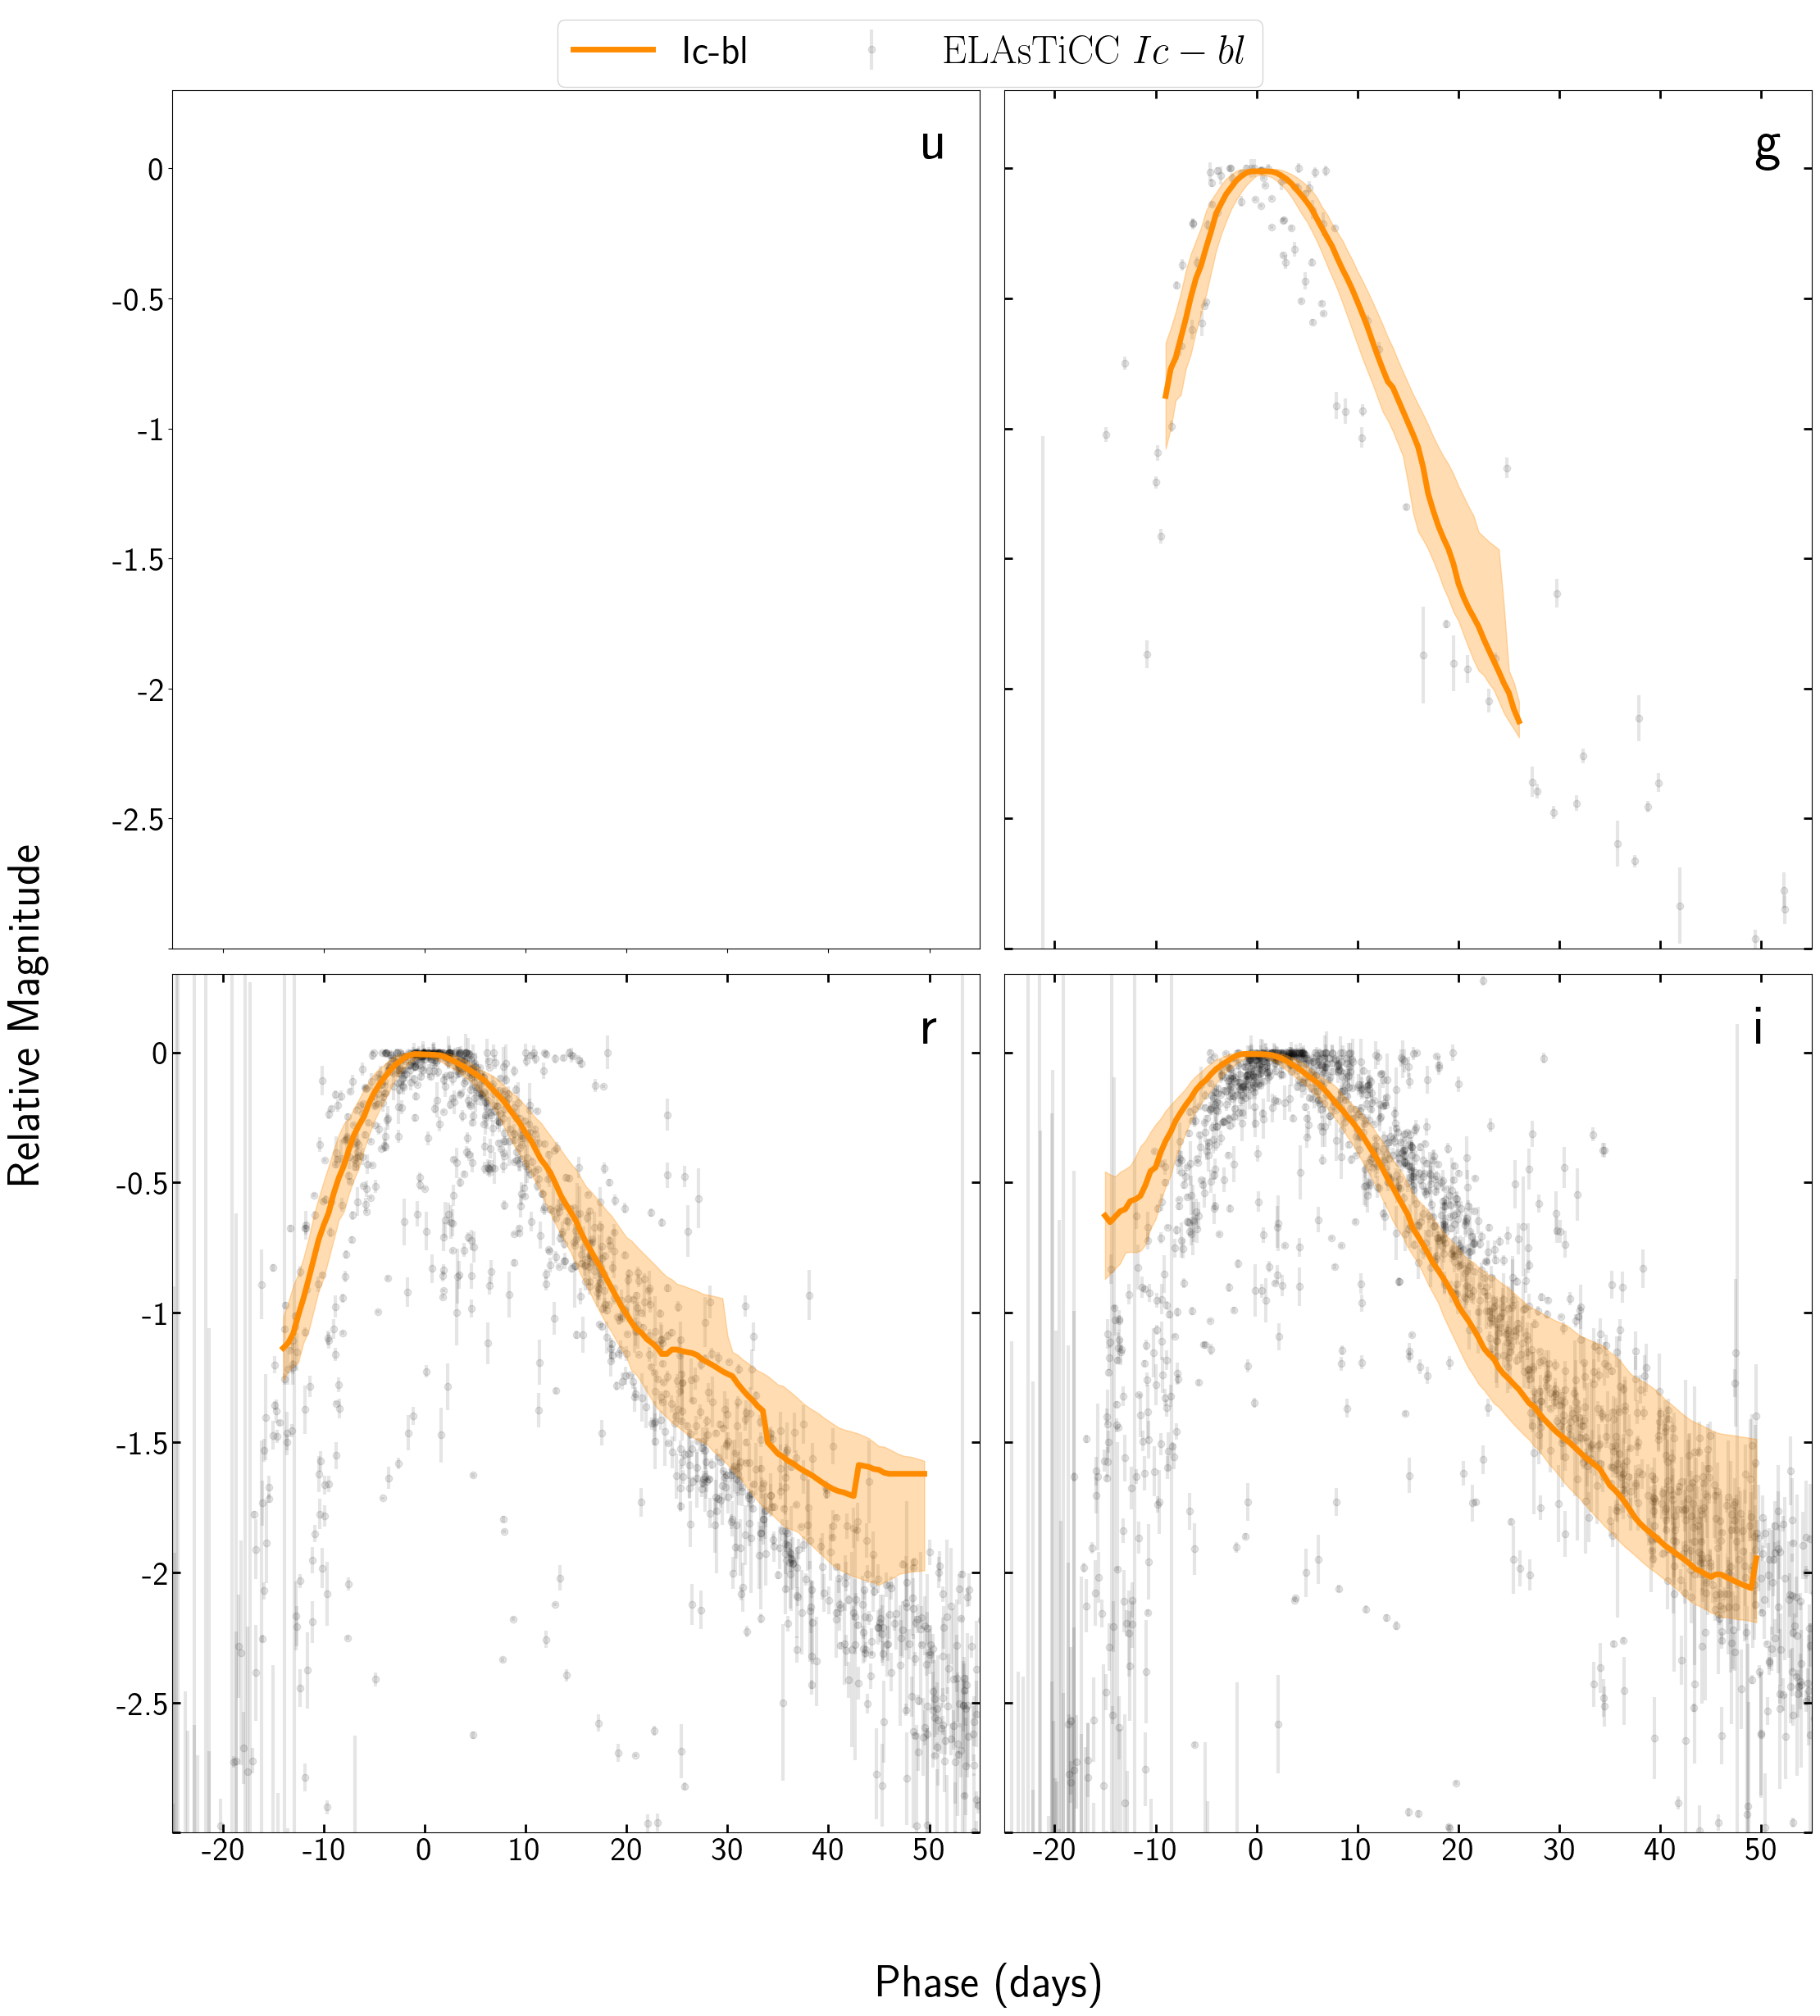

In [15]:
# ugrizy = 012345
bb = ['u','g','r','i']
b_ = [0,1,2,3]



# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
elasticc_sntype = {'Ib':['ELASTICC_TRAIN_SNIb+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIb-Templates/'],
                   'Ic':['ELASTICC_TRAIN_SNIc+HostXT_V19/',
                         'ELASTICC_TRAIN_SNIc-Templates/'],
                   'Ic-bl':['ELASTICC_TRAIN_SNIcBL-+HostXT_V19/']}

SNTYPES_ = {'Ib':['Ib', 'Ibn'],
            'Ic':['Ic'],
            'Ic-bl':['Ic-bl']}

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)

        
    
for sntype in list(elasticc_sntype.keys()):
    j_tmp = 0
    
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))
    
    for i, path in enumerate(elasticc_sntype[sntype]):
        
        
        directory = lc_direc + path.split('/')[0] + '.pkl'
        sne = pkl.load(open(directory, "rb"))
        
        for j, key in enumerate(list(sne.keys())):
            data1 = sne[key]

            for b in data1.keys():

                data = data1[b]

                x_peak = data['x_peak']
                x = data['x']
                y = data['y']
                yerr = data['y']
                m = data['m']
                merr = data['merr']

                mmax = np.min(m)
                ind = (x - x_peak <20) & (x - x_peak >-20)
        
                xx = x[ind]

                tt = tt = np.linspace(xx.min(), xx.max(), 1000)

                if len(xx)<4:
                    continue

                interpld = interp1d(xx, m[ind], kind='cubic')(tt)

        #         if len(m_func[ind_ymin]) == 0:
        #             tot -= 1
        #             continue
                mmax = np.min(interpld)


                if i == 0 and b == 'r' and j_tmp == 0:
                    j_tmp = 1
                    np.concatenate(ax)[b_index[b]].errorbar(x - x_peak,\
                        mmax - m , yerr=merr, fmt='o',\
                        linewidth = 3, color = 'k',
                        label = r'$\mathrm{ELAsTiCC }\;$'+'$'+sntype+'$', alpha = 0.1)
        #             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
        #                 new_y_peak - m_func,\
        #                 '-', linewidth = 0.1, color = 'k', alpha = 0.1, label = 'VL fit')


                else:
                    np.concatenate(ax)[b_index[b]].errorbar(x - x_peak,\
                        mmax - m , yerr=merr, fmt='o',\
                        linewidth = 3, color = 'k', alpha = 0.1)
        #             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
        #                 new_y_peak - m_func,\
        #                 '-', linewidth = 0.1, color = 'k', alpha = 0.1)


    for j, b in enumerate(bb):

        for tp in SNTYPES_[sntype]:

            if tp != sntype:
                alpha = 1
                zorder = 15
            else:
                alpha = 1
                zorder = 19

            if len(tmpl[b][tp]) == 0:
                continue

            if b == 'r':

                np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],
                        tmpl[b][tp]['rollingMedian'],
                        '-',color = colorTypes[tp], alpha = alpha,
                        linewidth=5, zorder = zorder, label = tp)
                np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                        tmpl[b][tp]['rollingPc25'],\
                        tmpl[b][tp]['rollingPc75'],\
                        alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)

            else:


                if b == 'g' and tp == 'Ic':

                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingMedian'][tmpl[b][tp]['t']<35],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc25'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc75'][tmpl[b][tp]['t']<35],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)
                else:
                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingMedian'],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingPc25'],\
                            tmpl[b][tp]['rollingPc75'],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)

            np.concatenate(ax)[b_[j]].tick_params(axis="both", direction="in", which="major",\
                                                  right=True, top=True, size=7, labelsize=25, width = 2)

        np.concatenate(ax)[b_[j]].text(0.93, 0.92, b, transform=np.concatenate(ax)[b_[j]].transAxes,\
                                   weight='bold', size = 50, color = 'k')

    handles, labels = np.concatenate(ax)[2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':35})
    np.concatenate(ax)[0].set_xlim(-25,55)
    np.concatenate(ax)[0].set_ylim(-3,0.3)
    np.concatenate(ax)[0].set_yticks([0, -0.5, -1, -1.5, -2, -2.5, -3])
    np.concatenate(ax)[0].set_yticklabels([ '0','-0.5',  '-1', '-1.5', '-2', '-2.5', ''], size=30)
    np.concatenate(ax)[2].set_yticklabels(['0','-0.5',  '-1', '-1.5', '-2', '-2.5', ''], size=30)

    np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
    np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)



    plt.subplots_adjust(hspace=.03, wspace=0.03, top = 0.95, left = 0.1, bottom = 0.1)

    fig.text(0.5, 0.02, 'Phase (days)', ha='center', size = 40)
    fig.text(0.02, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)


#     plt.savefig('Elasticc_lc_type_'+ sntype + '_cubic_interpol.pdf',
#                 bbox_inches='tight')